# Imports de bibliotecas

In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from scipy.integrate import solve_ivp
import matplotlib.pyplot as pl
import scipy.io

# Importando Arquivos

In [189]:
Dados = pd.read_csv ('dados/Dados_novos_BAHIA.csv')

Psi = scipy.io.loadmat('dados/Psi_Ba13set.mat')
# Pega a lista de itens referentes aos psi do arquivo .mat 
# no terceiro index do array Psi
Psi = list(Psi.values())[3]


# Média móvel do PSI

In [190]:
npd = len(Psi)
Nfo = 8

Psif = [[0]]*npd

for k in range(1, npd):
    if (k-Nfo) < 0 :
        Psif[k] = 1/k*sum(Psi[0:k])
    else:
        Psif[k] = 1/Nfo*sum(Psi[k-Nfo:k])

Psif.pop(0)
Psif = np.concatenate(Psif).ravel().tolist()


# Separacao de dados

In [191]:
casos_dados = Dados['Casos acumulados'].fillna(0)

recuperados_dados = Dados['Recuperados'].fillna(0)

mortos_dados = Dados['Mortos'].fillna(0)

hospitalizados_dados = Dados['Hospitalizados'].fillna(0)

uti_dados = Dados['UTI'].fillna(0)

vacinados_dados = Dados['Vacinados'].fillna(0)

novos_casos = np.diff(casos_dados)
novos_mortos = np.diff(mortos_dados)

inicio_da_vacinacao = 19


# Condicoes iniciais

In [192]:
D0          = mortos_dados[0] # 9159
N0          = 14930634
R0          = 478198
H0          = hospitalizados_dados[0] # 477
HV0         = 0
U0          = uti_dados[0] # 737
UV0         = 0
V0          = vacinados_dados[0] # 0
Rv0         = 0
Is0         = casos_dados[0]-451240
Ia0         = Is0*0.9
Iav0        = 0
Isv0        = 0 
E0          = (518955-casos_dados[0])
Ev0         = 0
S0          = (14930634-Is0-Ia0-E0)
Nw0         = 0
NwV0        = 0

condicoes_iniciais = [S0,E0,V0,Ev0,Ia0,Is0,Iav0,Isv0,H0,HV0,U0,UV0,R0,Rv0,D0,Nw0,NwV0];

# Modelo

In [193]:
def seiihurd(t, y):
    
    N=14930634
    psi=Psif[int(t)]
    tau=np.diff(vacinados_dados)[int(t)]

    k = 1/4
    gamma_a = 1/3.5
    gamma_s = 1/4
    gamma_h = 0.18
    gamma_u = 0.13342706158133355
    mi_u = 0.4
    qsi = 0.53
    h = 0.06
    h_v = 0
    mi_h = 0.15
    ome_h = 0.14
    ome_u = 0.29
    delta = 0.31
    p = 0.2
    
    if t<20.178:
        beta=2.1317
    elif (t>=20.178-8) and (t < 72.94):
        beta=1.7645
    elif (t>=72.94) and (t < 148):
        beta=1.1281
    else:
        beta=1;

    beta_v = beta*0.5
    
    if t<19:
        delta_av = 0;
        delta_sv = 0;
        phi_e = 0;
        k_v=0;
        p_v = 0;
        gamma_av = 0;
        gamma_sv = 0;
        gamma_vu=0;
        qsi_v = 0 ;
        eps=0;
        mi_vh=0;
        mi_vu=0;
        gamma_vh=0;
    else:
        delta_av = 0.31;
        delta_sv = 0.31;
        phi_e = 1/14;
        k_v=1/3;
        p_v = 0.1;
        gamma_av = 1/3.5;
        gamma_sv = 1/4;
        gamma_vu=0.26;
        qsi_v = 0.99;
        eps=0.7;
        mi_vh=0.03;
        mi_vu=0.25;
        gamma_vh=0.08;

    S=y[0]
    E=y[1]
    Sv=y[2]
    Ev=y[3]
    Ia=y[4]
    Is=y[5]
    Iav=y[6]
    Isv=y[7]
    H=y[8]
    Hv=y[9]
    U=y[10]
    Uv=y[11]
    R=y[12]
    Rv=y[13]
    D=y[14]
    Nw=y[15]
    NwV=y[16]

    dSdt = -(1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - tau/N;
    dEdt = (1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - k*E;
    dSvdt = tau/N - (1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - phi_e*eps*Sv;
    dEvdt = (1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - k_v*Ev;
    dIadt = (1-p)*k*E - gamma_a*Ia;
    dIsdt = p*k*E - gamma_s*Is;
    dIavdt = (1-p_v)*k_v*Ev - gamma_av*Iav;
    dIsvdt = p_v*k_v*Ev - gamma_sv*Isv;
    dHdt = h*qsi*gamma_s*Is + (1-mi_u+ome_u*mi_u)*gamma_u*U - gamma_h*H;
    dHvdt = h_v*qsi_v*gamma_sv*Isv + (1-mi_vu+ome_u*mi_vu)*gamma_vu*Uv - gamma_vu*Hv;
    dUdt = h*(1-qsi)*gamma_s*Is + ome_h*gamma_h*H - gamma_u*U;
    dUvdt = h_v*(1-qsi_v)*gamma_sv*Isv + ome_h*gamma_h*Hv - gamma_u*Uv;
    dRdt = gamma_a*Ia + (1-h)*gamma_s*Is + (1-mi_h)*(1-ome_h)*gamma_h*H - phi_e*eps*Sv;
    dRvdt = gamma_av*Iav + (1-h)*gamma_sv*Isv + (1-mi_vh)*(1-ome_h)*(gamma_vh*Hv);
    dDdt = (1-ome_h)*(mi_h*gamma_h*H +mi_vh*gamma_vh*Hv) + (1-ome_h)*(mi_u*gamma_u*U+mi_vu*gamma_vu*Uv);
    dNwdt = p*k*E + p_v*k_v*Ev;
    dNwVdt = tau/N;
    
    return [dSdt, dEdt, dSvdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt, dHdt, dHvdt, dUdt, dUvdt, dRdt, dRvdt, dDdt, dNwdt, dNwVdt]


# Chamando modelo

In [194]:
resultados = solve_ivp(seiihurd, [0,192], condicoes_iniciais, method='RK45', t_eval=np.arange(192))
resultados_modelo = resultados.y

Sm = N0*resultados_modelo[0,:]
Em = N0*resultados_modelo[1,:]
Svm = N0*resultados_modelo[2,:]
Evm = N0*resultados_modelo[3,:]
Iam = N0*resultados_modelo[4,:]
Ism = N0*resultados_modelo[5,:]
Iavm = N0*resultados_modelo[6,:]
Isvm = N0*resultados_modelo[7,:]
Hm = resultados_modelo[8,:]
Hvm = N0*resultados_modelo[9,:]
Um = N0*resultados_modelo[10,:]
Uvm = N0*resultados_modelo[11,:]
Rm = N0*resultados_modelo[12,:]
Rvm = N0*resultados_modelo[13,:]
Dm = N0*resultados_modelo[14,:]
Nwm = N0*resultados_modelo[15,:]
NwVm = N0*resultados_modelo[16,:]


# Plotando graficos

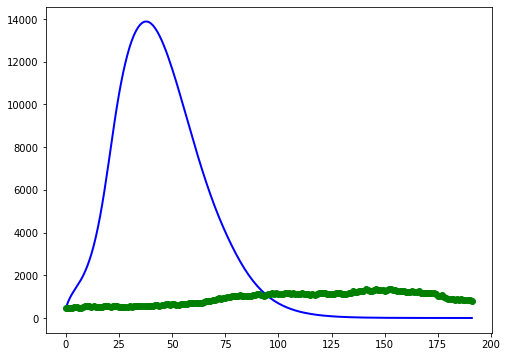

In [197]:
ts1=np.arange(192)
fig, ax = pl.subplots(figsize=(8,6))

ax.plot(ts1,  Hm, color='b',zorder=1, linewidth=2)
ax.scatter(ts1, hospitalizados_dados[:192], color='g',zorder=1, linewidth=1)